In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [3]:
def calculate_fitness(agent):
    return np.sum(100-(np.abs(agent-7)))

In [28]:
def sine(x, period=100, offset=0, max=1):
    x = x+offset
    return (np.sin(2*x*np.pi/period)/2 + 0.5) * max

def sawtooth(x, period=100, offset = 0, max=1):
    x = x+offset
    return ((x%period)/period) * max

def exponentialsawtooth(x, period=100, offset = 0, exponent=2, max=1):
    x = x+offset
    return (((x%period)/period) ** exponent) * max

def exponentialsine(x, period=100, offset = 0, exponent=2, max=1):
    x = x+offset
    return ((np.sin(2*x*np.pi/period)/2 + 0.5) ** exponent) * max

In [100]:
def calculate_fitness_array(agents):
    fitnesses = np.array([calculate_fitness(agent) for agent in agents])
    return fitnesses

def calculate_reproduction_chance(agents, epoch=1, value_uniqueness = 0.5):
    fitnesses = calculate_fitness_array(agents)
    fitnesses = (fitnesses-np.mean(fitnesses))/np.std(fitnesses)
    
    if value_uniqueness:
        gene_uniqueness = np.array([distance(np.mean(agents, axis=1), agent) for agent in agents])
        gene_uniqueness = (gene_uniqueness-np.mean(agents))/np.std(gene_uniqueness)

        reproduction_chance = fitnesses + (gene_uniqueness * value_uniqueness)
        reproduction_chance = (reproduction_chance-np.mean(reproduction_chance))/np.std(reproduction_chance)

        return reproduction_chance+2
    
    return fitnesses+2

def distance(x1, x2):
    return np.linalg.norm(x1-x2)

def mutate_agent(agent, rate, bounds):
    
    if rate < 1/1000000:
        return agent
    
    mutations = np.random.uniform(0,1/rate, size=agent.shape)
    mutations[mutations>1] = 0
    
    agent[mutations!=0] += np.random.normal(0, (bounds[1]-bounds[0]) ** 0.4, mutations[mutations!=0].shape).astype(np.int32)
    agent[agent<bounds[0]] = bounds[0]
    agent[agent>bounds[1]] = bounds[1]
    
    return agent

def mutate_array(agents, rate, bounds):
    mutated_agents = np.array([mutate_agent(agent, rate, bounds) for agent in agents])
    return mutated_agents

def merge_genes(a, b, n_genes):
    merged = np.zeros(shape=(n_genes, int(a.shape[0]/n_genes)))
    
    genes_a = a.reshape(n_genes, int(a.shape[0]/n_genes))
    genes_b = b.reshape(n_genes, int(b.shape[0]/n_genes))
    to_merge = np.random.randint(0,2, size=(n_genes))

    merged[to_merge == 0] = genes_a[to_merge == 0]
    merged[to_merge == 1] = genes_b[to_merge == 1]
    
    return merged.reshape(-1)

def genes_to_rgb(agent):
    RGB_driver = agent.reshape(8, 3, int(agent.shape[0]/24))
    image_pixels = np.zeros(shape=(1, int(agent.shape[0]/24), 3))
    for i, pixel in enumerate(RGB_driver):
        for j, channel in enumerate(pixel):
            image_pixels[0][i][j] = channel.dot(2**np.arange(channel.size)[::-1])
    return image_pixels.astype(int)

def show_n_agents(agents, n):
    fig, ax = plt.subplots(round(n/8),8,figsize=(12,6))
    img = []
    indices = np.random.randint(0,agents.shape[0], size=(n))
    for i, index in enumerate(indices):
        ax[i].imshow(agents[index].reshape(10,10), cmap='plasma', vmin=agent_bounds[0], vmax=agent_bounds[1])
        ax[i].axis('off')
        
def calculate_entropy(agents):
    entropy = np.zeros(agents.shape[1])
    for col in range(agents.shape[1]):
        unique, counts = np.unique(agents[:,col], return_counts=True)
        for i, count in enumerate(counts):
            entropy[col] += (count/np.sum(counts) * (np.sum(counts) - count)/np.sum(counts))
    return np.mean(entropy)

def next_generation(agents, generation=0, mutation_rate=0.01, value_diversity = 0.5):
    
    fitnesses = calculate_reproduction_chance(agents, epoch=i, value_uniqueness=value_diversity)
    gene_pool = np.array(random.choices(current_generation, weights = fitnesses, k=current_generation.shape[0]*2))
    
    next_generation = np.array([merge_genes(gene_pool[i], gene_pool[i+1], 10) for i in range(int(len(gene_pool)/2))])
    next_generation = mutate_array(next_generation, mutation_rate, agent_bounds)
    return next_generation

In [101]:
num_genes = 100 
num_agents = 100
num_generations = 1000
mutation_rate = 0.05
agent_bounds = (0,100) #Inclusive

In [129]:
current_generation = np.random.randint(agent_bounds[0], agent_bounds[1]+1, size=(num_agents, num_genes))
first_generation = np.copy(current_generation)
history = []
genetic_diversity = []


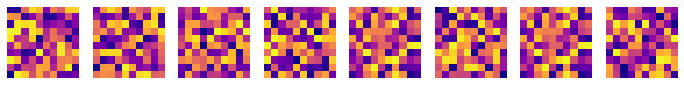

In [130]:
show_n_agents(current_generation, 8)

In [131]:
num_generations = 1000
for i in range(num_generations):
    gen_mutation_rate = sine(i, period=125, max=mutation_rate, offset = -25)
    uniqueness_value = sine(i, 250, offset = -50, max=0.5)
    
    current_generation = next_generation(current_generation, generation=i, mutation_rate=mutation_rate, value_diversity = uniqueness_value)
    
    history.append(np.mean([calculate_fitness(agent) for agent in current_generation])/num_genes)
    genetic_diversity.append(np.mean([distance(np.mean(current_generation, axis=1), agent) for agent in current_generation]))

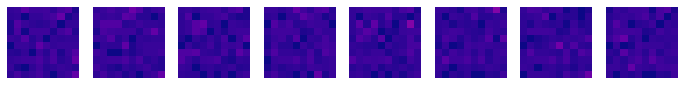

In [132]:
show_n_agents(current_generation, 8)
best = current_generation[np.argmax(calculate_reproduction_chance(current_generation, value_uniqueness=False))]

Final diversity score: 39.15109387238781


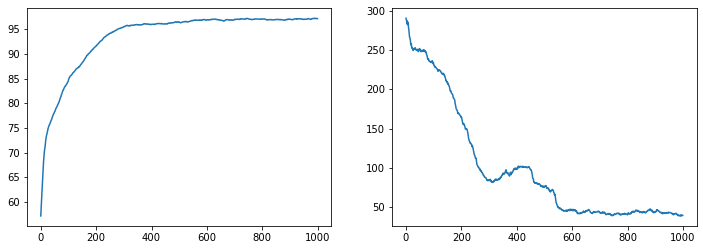

In [133]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.arange(0, len(history)), history)
ax[1].plot(np.arange(0, len(genetic_diversity)), genetic_diversity)
print(f'Final diversity score: {genetic_diversity[-1]}')

In [142]:
num_generations = 1000
for i in range(num_generations):
    gen_mutation_rate = 0.001
    uniqueness_value = 0
    
    current_generation = next_generation(current_generation, generation=i, mutation_rate=mutation_rate, value_diversity = uniqueness_value)
    
    history.append(np.mean([calculate_fitness(agent) for agent in current_generation])/num_genes)
    genetic_diversity.append(np.mean([distance(np.mean(current_generation, axis=1), agent) for agent in current_generation]))

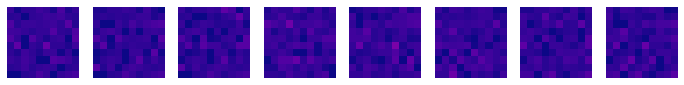

In [146]:
show_n_agents(current_generation, 8)
best = current_generation[np.argmax(calculate_reproduction_chance(current_generation, value_uniqueness=False))]

Final diversity score: 40.45390563767509


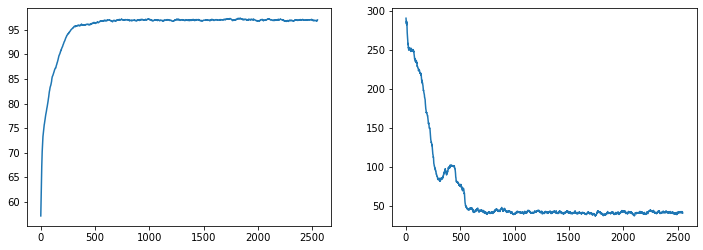

In [144]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.arange(0, len(history)), history)
ax[1].plot(np.arange(0, len(genetic_diversity)), genetic_diversity)
print(f'Final diversity score: {genetic_diversity[-1]}')

In [138]:
from sklearn.decomposition import PCA

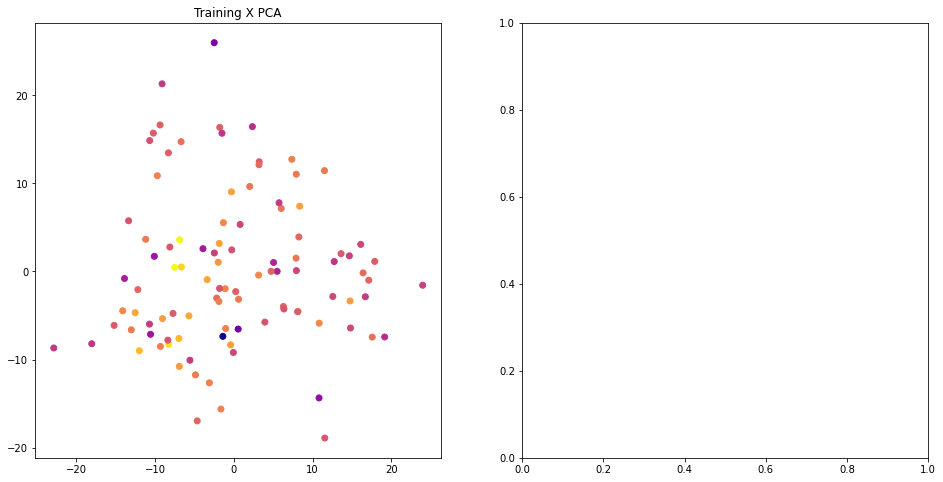

In [145]:
pca = PCA(n_components=2)
pca.fit(current_generation);

X_train_pca = pca.transform(current_generation)
y_train = calculate_reproduction_chance(current_generation)
y_train2 = calculate_reproduction_chance(current_generation, value_uniqueness=0)

fig, axis = plt.subplots(1, 2, figsize=(16,8))
axis[0].scatter(X_train_pca[:,0], X_train_pca[:,1] , c=np.array(y_train).reshape(-1,1), cmap="plasma")
axis[0].title.set_text('Training X PCA')